Necessary Imports 

In [66]:
import numpy as np 
import os 
import datetime
import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from scipy.optimize import minimize
from itertools import product
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

### Make the 'truth' and save to disk 

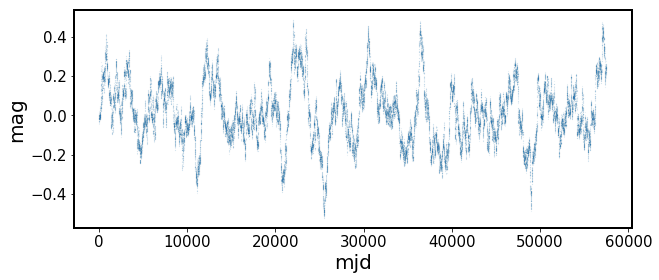

In [2]:
# Simulate 10'000 light curves

def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag



# input tau = 575 days 

tau_in = 575 # days 
SF_inf = 0.2 # mag 

T = 100 * tau_in   # baseline
dt = 1 # day  
t_min = 0 # start time 
t_max = t_min + T # end time 
t = np.arange(t_min, t_max, dt)  # simulation 'truth' points 

y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

# show what this realization looks like .... 
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.scatter(t,y,s=0.001)
ax.set_xlabel('mjd')
ax.set_ylabel('mag')

In [ ]:
# No offset or error , 
# since this is the 'truth', not the observation 

In [39]:
# save sampling times separately 
np.savetxt(outDir + 'DRW_times_dt-0.1_T-57500d.txt', t, fmt='%.2d' )


In [38]:
# Loop saving into dic and then dumping dic as npy pickle...
# 328 MB for 1000 lightcurves , 
# so it would be 3 GB for 10 000 light curves ...
outDir = '../data_products/DRW_Kozlowski_Simulate/'
results = {}
for i in range(1000) : 
    print(i)
    y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0) # exactly the same points 
    # since we are using a regular grid for the truth ... 
    results[i] = {'y':y}

name = 'DRW_tau-575_dt-1_SF-0.2_results'
np.save(outDir+name,results, fmt='%.2d')

0
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

'00600'

In [53]:
# Loop over 10000 realizations, saving each time mjd and mag. 

outDir = '../data_products/DRW_Kozlowski_Simulate/'
for i in range(1000) : 
    print(i)
    y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0) # exactly the same points 
    # since we are using a regular grid for the truth ... 
    name = 'DRW_mags_' + str(i).zfill(5)+'.txt'
    np.savetxt(outDir+name,y, fmt = ' %.5f ')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Sample the 'truth'

In [ ]:
# Because our 'true' light curve has the
# length 57500 points,  
# starting at t=0,  to t = 57500 days.
# so the minimum length that we can probe would 
# depend on the N_obs we are trying to sample 

# Since we sample every 1 day in the true light curve, 
# t_max = N_obs  at the very least .
# Thus for N_obs = 60, t_max = 60 days, 
# i.e. length_min = t_max / tau_in = 60 / 575 ~ 0.1 
# so that rho_max = 1  / length_min ~ 10 

# On the other hand,  if we choose the number 
# of points to be 200,  then N_obs = 200,  and t_max = 200 days, 
# so that length_min = 200 / 575 ~ 0.5,  
# and rho_max = 1 / length_min ~ 2 

# And finally for  N_obs  = 1000,  t_max = 1000 days, 
# so that length_min = 1000 / 575 ~ 2  , 
# and rho_max ~ 1 / length_min ~ 0.5 




In [67]:

def fit_lightcurves(SF_inf = 0.2, noise=0.001, sampling='regular', 
                    N_obs =1000, n_rho_grid=100, 
                    n_lightcurves=1000 ) : 
    ''' A convenience function to use all simulated light curves
    that have SF_inf = 0.2, tau_in = 575 days,  length = 100 * tau_in,  
    dt = 1 day.  Given our choice of how many points to sample, set by
    N_obs ( t_min = N_obs since dt = 1 day),   we can choose light curve 
    sections  of length from length_min = t_min/ tau_in,
    to length_max = t_max / tau_in = (100 * tau_in )/ tau_in = 100.
    This corresponds to  rho_max = 575 / N_obs, and 
    rho_min = 1 / 100 . This sets up a logarithmic  grid that we 
    sample  with n_rho_grid,  between  rho_min and rho_max.  
    '''

    # setup for fitting 
    sigma_in = SF_inf / np.sqrt(2)
    sigma_bounds = [0.01, 1.0]
    tau_bounds = [1,10000]

    # Loop over sampling density,   selection regularity,   noise level 
    #noise = 0.001 # choose photometric noise in magnitudes   
    #sampling = 'regular' # choose sampling type 
    #N_obs = 1000 # choose density of sampling : try 60, 200, 1000
    #yerr = 0.01 # homoscedastic errors 

    # set how dense should be the rho_grid...
    #n_rho_grid = 100

    # Iterating over just these settings would result in : 
    # { Regular / Random sampling  } x  { 60, 200, 1000 points} x {0.001, 0.01, 0.1 mag noise} 
    #  -->  18 different panels 

    # this step ensures that there are more than N_obs points  
    # in the light curve  section from which we are sampling..
    rho_max = tau_in / N_obs  
    length_min = 1 / rho_max 

    print('For N_obs = %d,  minimum length = %.3f tau,  \
    which means maximum rho= %.3f '%(N_obs,length_min, rho_max))

    # the longest section we can choose is the full length ... 
    rho_min = 1 / 100.0    # since the 'true' light curves have length 100 tau ... 

    # load the 'true' sample times  : 
    # the same since these are uniform dt from
    # 0 to 57500 over dt=1 day
    t = np.loadtxt(outDir + 'DRW_times_dt-1d_T-57500d.txt')

    # Loop over light curves 
    # Load the times and y values of a light curve ...  
    results = np.zeros(n_lightcurves, dtype=object)
    print('We have %d light curves to fit, using sections \
    defined by the grid of rho'%n_lightcurves)
    for i in range(n_lightcurves) : 
        if i %  100 == 0 :
            print(i) # print every hundreth.. .
        y = np.loadtxt(outDir+'DRW_mags_'+str(i).zfill(5)+'.txt')

        # Then I select various sections of the same light curve: 
        # rho_in =  tau_in / baseline = tau_in / t_exp = tau_in / (length * tau_in) = 1 / length
        # Record rho_out  as a function of rho_in  and N_points
        # And do that on a grid of rho_in  stretching from rho_min to  rho_max 
        # where rho_max depends on N_points 

        # Thus  I can plot figures like Kozlowski+2017, where the only difference between the two 
        # panels is how many points were used. As he shows, there should not be much difference

        # each section of length  =  tau_in *  ( 1 / rho_in)
        # each section starts at t = 0 

        rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho_grid)

        # initialize storage for this light curve 
        results[i] = {'rho_in' : rho_grid, 'rho_out':np.zeros_like(rho_grid),
                     'sigma_fit' :np.zeros_like(rho_grid),
                     'tau_fit' : np.zeros_like(rho_grid)
                     }

        count = 0 
        for rho_in in rho_grid : 
            length =  1 / rho_in 
            #print('Using length = %d tau '%length)
            t_exp = length * tau_in  # same as t_exp in Kozlowski 
            #print('tmax = %d'%tmax)
            t_select = t[t<t_exp]  # choose length to sample
            y_select = y[t<t_exp]
            #print('There are %d points in that section'%len(t_select))

            if sampling is 'random' :
                # random sampling 
                indices = np.sort(np.random.randint(low=0,high=len(t_select), size=N_obs))
            if sampling is 'regular' : 
                # uniform sampling
                indices = np.linspace(0, len(t_select)-1, N_obs, dtype=int)
            #print('But we choose only %d '%len(indices))
            t_obs = t_select[indices]
            y_obs_ideal = y_select[indices]

            ## Add Gaussian noise 
            y_offset = np.random.normal(loc=0, scale=noise, size = len(t_obs))
            y_obs = y_obs_ideal + y_offset

             # illustrate what we do 
            plot = False
            if plot : 
                fig,ax = plt.subplots(1,1,figsize=(10,4))
                ax.scatter(t,y,s=0.001)
                ax.scatter(t_obs, y_obs, s=10, c='red', marker='o')
                ax.set_title('T='+str(length)[:5]+r'$*\tau$' + ', N='+str(N_obs))
                plt.savefig(outDir + 'Fig_sampling_illustrate_T-'+\
                            str(length)+'_N-'+str(N_obs)+'.png')

            # fit with Celerite ... 
            # Use Celerite to fit the observed light curve  with flat prior 

            # fitting procedure : 
            # initialize the kernel ... 
            log_a_in = 2 * np.log(sigma_in)
            log_c_in = np.log(1/tau_in)
            kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

            # call the model 
            gp = celerite.GP(kernel, mean=np.mean(y_obs))
            gp.compute(t_obs, noise) #y_err is photometric noise

            # optimization of the results 
            initial_params = gp.get_parameter_vector()

            # use custom bounds for starters .... 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]

            # use flat prior ... 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

            # do the scipy optimize to find the maximum likelihood estimate
            # for the hyperparameters 
            r = minimize(neg_log_like, initial_params, 
                         method="L-BFGS-B", bounds=bounds, args=(y_obs, gp))
            gp.set_parameter_vector(r.x)
            res = gp.get_parameter_dict()
            sigma_fit = np.exp(res['kernel:log_a']/2)
            tau_fit = 1.0 / np.exp(res['kernel:log_c'])
            #print('sigma_fit=%.3f, tau_fit = %.3f'%(sigma_fit, tau_fit))

            results[i]['sigma_fit'][count] = sigma_fit
            results[i]['tau_fit'][count] = tau_fit
            results[i]['rho_in'][count] = rho_in
            rho_out = tau_fit / t_exp
            results[i]['rho_out'][count] = rho_out
            count += 1 
    return results 

In [68]:
# run over a grid of params and save results ...

# Parameter space : 
# { Regular / Random sampling  } x  { 60, 200, 1000 points} x {0.001, 0.01, 0.1 mag noise}


for sampling, noise, N_obs in product(['regular', 'random'], 
                                      [0.001, 0.01, 0.1], 
                                     [60,200,1000 ]):
    print('Using %s sampling,  %f noise, and %d observed points'%(sampling,noise, N_obs))
    params = {'noise':noise, 'sampling':sampling, 
            'N_obs' :N_obs}
    
    results = fit_lightcurves(noise=noise, sampling=sampling, 
                        N_obs =N_obs)

    # Save the results for the particular set of 
    # parameters ...
    
    fname  = outDir+'Celerite_fit_params_'+sampling+str(noise)+str(N_obs) 
    np.save(fname, params)
    print('Saved params in %s'%fname)
    
    fname = outDir+'Celerite_fit_results_'+sampling+str(noise)+str(N_obs)
    np.save(fname, results)
    print('Saved results in %s'%fname)



Using regular sampling,  0.001000 noise, and 60 observed points
For N_obs = 60,  minimum length = 0.104 tau,      which means maximum rho= 9.583 
We have 1000 light curves to fit, using sections     defined by the grid of rho
0
100
200
300
400
500
600
700
800
900
Saved params in ../data_products/DRW_Kozlowski_Simulate/Celerite_fit_params_regular0.00160
Saved results in ../data_products/DRW_Kozlowski_Simulate/Celerite_fit_results_regular0.00160
Using regular sampling,  0.001000 noise, and 200 observed points
For N_obs = 200,  minimum length = 0.348 tau,      which means maximum rho= 2.875 
We have 1000 light curves to fit, using sections     defined by the grid of rho
0
100
200
300
400
500
600
700
800
900
Saved params in ../data_products/DRW_Kozlowski_Simulate/Celerite_fit_params_regular0.001200
Saved results in ../data_products/DRW_Kozlowski_Simulate/Celerite_fit_results_regular0.001200
Using regular sampling,  0.001000 noise, and 1000 observed points
For N_obs = 1000,  minimum length 

In [210]:
# Save the results for the particular set of 
# parameters ...

params = {'noise':0.001, 'sampling':'regular', 
        'N_obs' :N_obs, 'yerr':0.01}
np.save(outDir+'Celerite_fit_params_2' , params)
np.save(outDir+'Celerite_fit_results_2', results)



(0.01, 3.9463432877144857)

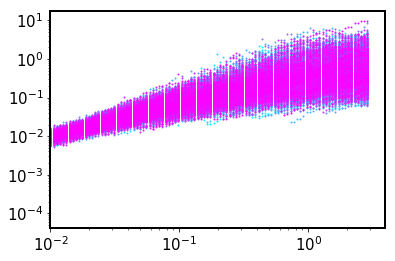

In [208]:

fig,ax = plt.subplots()

color_idx = np.linspace(0, 1, len(results))
for i in range(len(results)): 
    idx = color_idx[i]
    ax.scatter(results[i]['rho_in'],results[i]['rho_out'], s=1, color=plt.cm.cool(idx))
ax.loglog()
ax.set_xlim(0.01)

In [7]:
# load results to print ...
outDir = '../data_products/DRW_Kozlowski_Simulate/'
params = np.load(outDir+'Celerite_fit_params_0.npy').item()
print(params)
results = np.load(outDir+'Celerite_fit_results_0.npy')

{'noise': 0.001, 'sampling': 'regular', 'N_obs': 1000, 'yerr': 0.01}


In [21]:
rho_in = np.zeros(0) 
rho_out = np.zeros(0) 

for i in range(len(results)):
    rho_in = np.append(rho_in,  results[i]['rho_in'])
    rho_out = np.append(rho_out, results[i]['rho_out'])


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 100000 but corresponding boolean dimension is 176


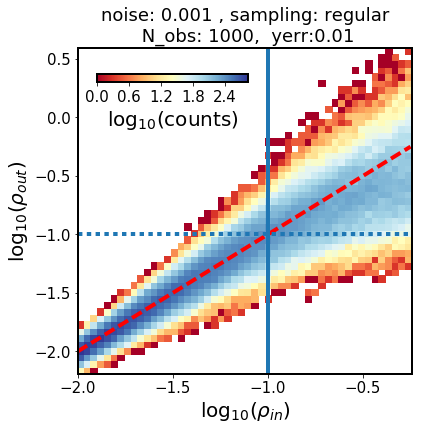

In [64]:
# Plot the 2D histogram...

%matplotlib inline
from scipy.stats import binned_statistic_2d
fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.log10(rho_in)
y = np.log10(rho_out)

stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                         cmap=plt.cm.get_cmap('RdYlBu'))

cax = fig.add_axes([0.17, 0.8, 0.35,0.02])
colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
colorbar.locator = tick_locator
colorbar.update_ticks()
colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
ax.set_ylabel(r'$\log_{10}(\rho_{out})$')
xlim = ax.get_xlim()
x = np.arange(xlim[0], xlim[1],0.01)
ax.plot(x,x, ls='--', lw=4, color='red')
ax.axhline(-1, ls=':', lw=4)
ax.axvline(-1, ls='-', lw=4)


mean_x = np.arange(xlim[0], xlim[1], 0.2)
median_y = np.zeros(len(mean_x)-1)
for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  (mean_x[j]< x )*(x<  mean_x[j+1])
    median_y[j] = np.median(y[mask])
    
#ax.scatter(mean_x[:-1], median_y, c = 'magenta', s=50)
ax.set_title('noise: '+ str(params['noise'])+' '+\
             ', sampling: '+ params['sampling'] +\
             '\n N_obs: '+str(params['N_obs'])+\
             ',  yerr:' +str(params['yerr']) )
plt.savefig(outDir+'Celerite_fits_setup0.png', bbox_inches='tight')

(0.01, 0.71178093732525405)

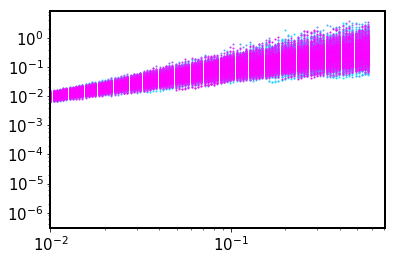

In [15]:
fig,ax = plt.subplots()

color_idx = np.linspace(0, 1, len(results))
for i in range(len(results)): 
    idx = color_idx[i]
    ax.scatter(results[i]['rho_in'],results[i]['rho_out'], s=1, color=plt.cm.cool(idx))
ax.loglog()
ax.set_xlim(0.01)

In [92]:

# Initialize results storing dictionary 
results = {}
for sampling in ['regular', 'random'] : 
    results[sampling]



array([  2.04526465e-02,  -1.76845167e-02,  -2.56200722e-02,
         1.50074207e-01,   3.37011971e-02,  -3.57629423e-02,
        -1.83171557e-01,  -9.53274191e-02,   8.82273531e-02,
         8.85748174e-02,   1.61791191e-01,   3.14287753e-01,
         2.70064495e-01,   1.72297246e-01,   1.87895661e-01,
         8.36361061e-02,   1.76184855e-01,   1.13482391e-01,
         1.03259476e-01,   8.00968343e-02,   4.26742632e-02,
        -7.36332394e-02,  -7.60174987e-02,   1.61802077e-01,
        -3.50948631e-02,  -2.24180827e-02,   3.52299836e-02,
         5.80364344e-02,   7.70834831e-03,   5.09104282e-02,
         6.45309882e-02,   5.36632518e-02,   1.37870137e-01,
        -7.17931450e-02,  -6.33747971e-02,  -4.25352020e-02,
        -1.47947986e-02,   7.81516420e-03,   6.25391633e-02,
         1.62544051e-01,   3.94584889e-02,   3.87027528e-02,
        -2.97651885e-03,   4.71681745e-02,  -2.61728714e-03,
        -8.51368655e-02,  -3.22229466e-02,  -3.87601240e-02,
         1.75595764e-02,

### Celerite fit 